In [1]:
import overpy
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
import cv2 

from shapely.geometry import Polygon
from shapely.ops import polygonize
from shapely.geometry import LineString

In [2]:
## Place appropriate Co-ordinates here to get the region areas.
## Also try the admin_levels in overpass query used by the specific regions or countries use for mapping in link below
## https://wiki.openstreetmap.org/wiki/Tag:boundary%3Dadministrative#11_admin_level_values_for_specific_countries
## E.g. Barcelona region has outskirts of the city included too, which require admin_level 10 and 9 together 
## whereas Moscow covers the city, and maps well with admin_level 8. play around with this to get better region informations
## and maybe group these together for good coverage.

# Barcelona   

# MIN_LAT = 41.2530
# MIN_LONG = 1.9205
# MAX_LAT = 41.6668
# MAX_LONG = 2.3566


# Moscow   

MIN_LAT = 55.5651
MIN_LONG = 37.3535
MAX_LAT = 55.9184
MAX_LONG = 37.8630

admin_level = 8

cv2_height, cv2_width = 3000, 3000

box = np.array([[MIN_LAT, MIN_LONG], [MAX_LAT, MAX_LONG]])

image_height, image_width = 495, 436 # Output width in pixels

bbox = (MIN_LAT, MIN_LONG, MAX_LAT, MAX_LONG)

overpass_api = overpy.Overpass()
result = overpass_api.query(f'''
(
  way["admin_level"="{admin_level}"]{bbox};
  relation["admin_level"="{admin_level}"]{bbox};
);
(._;>;);
out;
''' )

node_cols = ['id','lon','lat']
df_nodes = pd.DataFrame([[getattr(node,a) for a in node_cols] for node in result.nodes])\
    .rename(columns=dict(zip(range(len(node_cols)),node_cols)))

df_nodes = df_nodes.set_index(df_nodes.id)
del df_nodes['id']

df_ways = pd.DataFrame(np.concatenate([np.asarray([(w.id ,n.id, w.tags) for n in w.nodes]) for w in result.ways]))\
    .rename(columns={0:'way', 1:'node', 2:'tags'})

df_ways = df_ways.set_index(df_ways.way)
del df_ways['way']

df_relations = pd.DataFrame(np.concatenate(
    [np.asarray([(r.id,x.ref, r.tags) for x in r.members if isinstance(x, overpy.RelationWay)])\
     for r in result.relations]))\
    .rename(columns={0: 'rel', 1: 'way', 2: 'tags'})

df_relations = df_relations.set_index(df_relations.rel)
del df_relations['rel']
df_relations

,way,tags
rel,,
226927,206543634,"{'addr:country': 'RU', 'addr:region': 'Москва'..."
226927,206543632,"{'addr:country': 'RU', 'addr:region': 'Москва'..."
226927,206530336,"{'addr:country': 'RU', 'addr:region': 'Москва'..."
226927,206530309,"{'addr:country': 'RU', 'addr:region': 'Москва'..."
226927,206530305,"{'addr:country': 'RU', 'addr:region': 'Москва'..."
...,...,...
2162195,179982153,"{'admin_level': '8', 'alt_name': 'муниципальны..."
2162195,449099012,"{'admin_level': '8', 'alt_name': 'муниципальны..."
2162195,84039112,"{'admin_level': '8', 'alt_name': 'муниципальны..."


In [3]:
df_relations.to_csv("moscow_admin_lvl_8.csv")
# df_relations.to_csv("barcelona_admin_lvl_8.csv")

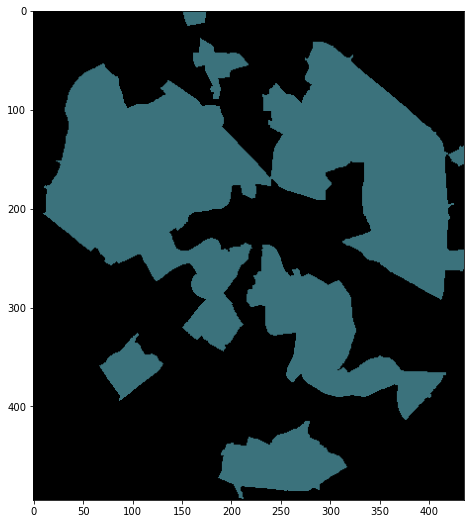

In [4]:

# boundaries
boundaries_rel = df_relations[df_relations.apply(lambda x: 'boundary' in x['tags'], axis=1)]['way']
boundaries_relation_ways = df_ways[df_ways.index.isin(boundaries_rel)]
boundaries_ways = df_ways[df_ways.apply(lambda x: 'boundaries' in x['tags'], axis=1)]
boundaries_ways = pd.concat([boundaries_relation_ways])
boundaries = boundaries_ways.groupby(['way']).node.apply(list)

def draw_polys(image, nodes_array, color):
    lines = []
    for nodes in nodes_array:
        coords = df_nodes.loc[nodes].values
        coords = coords.astype(float)
        coords = coords - [[bbox[1], bbox[0]]]
        coords = coords / [[bbox[3] - bbox[1], bbox[2] - bbox[0]]]
        coords = coords * [[width, height]]
        coords = coords.astype(int)
        lines.append(LineString(coords))
        polys = polygonize(LineString(coords))
        for poly in polys:
            cv2.fillPoly(image, pts = [np.array(poly.exterior.coords).astype(int)], color = color)
    
    polys = polygonize(lines)
    for poly in polys:
        cv2.fillPoly(image, pts = [np.array(poly.exterior.coords).astype(int)], color = color)
        
color_land = (0, 0, 0)
color_boundaries = (59, 114, 124)
        
width, height = image_width, image_height
image = np.full((height,width,3), color_land, np.uint8)

draw_polys(image, boundaries, color_boundaries)
image = cv2.flip(image, 0)
display_width, display_height = 12, 9
plt.figure(figsize=(display_width, display_height))
plt.imshow(image)
plt.show()